In [3]:
# 上傳檔案
from google.colab import files
uploaded = files.upload()

# 下載檔案
# from google.colab import files
# files.download('serviceAccount.json')

# 查看GPU資訊
# !nvidia-smi



Saving train_data.csv to train_data.csv


In [0]:
# 從 google drive上傳資料
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
import copy, time
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
# df_train = pd.read_csv('train_data.csv', index_col="name")
df_train = pd.read_csv('train_data.csv')
# df_test = pd.read_csv('test_features.csv', index_col="name")
df_test = pd.read_csv('test_features.csv')

names = df_test['name']
df_train.head()


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [3]:
df_train.keys()

Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'director_fees', 'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'loan_advances', 'long_term_incentive', 'other', 'poi',
       'restricted_stock', 'restricted_stock_deferred', 'salary',
       'shared_receipt_with_poi', 'to_messages', 'total_payments',
       'total_stock_value'],
      dtype='object')

In [0]:
# dataframe dimension
# df_train.info()

# df_train.dtypes

# df_train.shape

In [7]:
print('Columns:', list(df_train.columns.values))
print('Shape:', df_train.shape)
# 查看 poi 數量
print('Number of POI in the dataset:', (df_train['poi'] == 1).sum())
print('Number of non-POI in the dataset:', (df_train['poi'] == 0).sum())

Columns: ['name', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'email_address', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'poi', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']
Shape: (113, 22)
Number of POI in the dataset: 13
Number of non-POI in the dataset: 100


In [8]:
# convert to numpy.nan
df_train.replace(to_replace='NaN', value=np.nan, inplace=True)

# count number of nan for columns
print(df_train.isnull().sum())

# remove email address column
if 'email_address' in list(df_train.columns.values):
    df_train.drop('email_address', axis=1, inplace=True)

name                           0
bonus                         52
deferral_payments             85
deferred_income               79
director_fees                100
email_address                 30
exercised_stock_options       32
expenses                      40
from_messages                 48
from_poi_to_this_person       48
from_this_person_to_poi       48
loan_advances                111
long_term_incentive           64
other                         44
poi                            0
restricted_stock              31
restricted_stock_deferred    103
salary                        40
shared_receipt_with_poi       48
to_messages                   48
total_payments                17
total_stock_value             15
dtype: int64


In [9]:
# for df_test
# convert to numpy.nan
df_test.replace(to_replace='NaN', value=np.nan, inplace=True)

# count number of nan for columns
print(df_test.isnull().sum())

# remove email address column
if 'email_address' in list(df_test.columns.values):
    df_test.drop('email_address', axis=1, inplace=True)

name                          0
bonus                        12
deferral_payments            22
deferred_income              18
director_fees                29
email_address                 5
exercised_stock_options      12
expenses                     11
from_messages                12
from_poi_to_this_person      12
from_this_person_to_poi      12
loan_advances                31
long_term_incentive          16
other                         9
restricted_stock              5
restricted_stock_deferred    25
salary                       11
shared_receipt_with_poi      12
to_messages                  12
total_payments                4
total_stock_value             5
dtype: int64


In [10]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df_train)

,Missing Ratio
loan_advances,98.230088
restricted_stock_deferred,91.150442
director_fees,88.495575
deferral_payments,75.221239
deferred_income,69.911504
long_term_incentive,56.637168
bonus,46.017699
from_this_person_to_poi,42.477876
from_poi_to_this_person,42.477876
from_messages,42.477876


In [11]:
na_check(df_test)

,Missing Ratio
loan_advances,93.939394
director_fees,87.878788
restricted_stock_deferred,75.757576
deferral_payments,66.666667
deferred_income,54.545455
long_term_incentive,48.484848
from_this_person_to_poi,36.363636
exercised_stock_options,36.363636
from_messages,36.363636
from_poi_to_this_person,36.363636


In [0]:
# # 提取name
# names_train = df_train['name']
# names_test = df_test['name']

# train_Y = df_train['poi']

# df_train = df_train.drop(['name', 'poi'] , axis=1)
# df_test = df_test.drop(['name'], axis=1)

# # 串接 df_train 與 df_test
# df = pd.concat([df_train, df_test])


In [0]:
# feature 分組
payments_features = ['salary', 'bonus', 'long_term_incentive',
                     'deferred_income', 'deferral_payments', 'loan_advances',
                     'other', 'expenses', 'director_fees', 'total_payments']

stock_features = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred','total_stock_value']
email_features = ['to_messages', 'from_poi_to_this_person',
                  'from_messages', 'from_this_person_to_poi',
                  'shared_receipt_with_poi']

target_field = 'poi'

In [13]:
# 填補缺失值
df_imp = df_train.replace(to_replace=np.nan, value=0.0, inplace=True)
df_imp = df_train.fillna(0).copy(deep=True)
df_imp.columns = list(df_train.columns.values)

print(df_imp.isnull().sum())
print(df_imp.head())

df_imp.describe()

name                         0
bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
exercised_stock_options      0
expenses                     0
from_messages                0
from_poi_to_this_person      0
from_this_person_to_poi      0
loan_advances                0
long_term_incentive          0
other                        0
poi                          0
restricted_stock             0
restricted_stock_deferred    0
salary                       0
shared_receipt_with_poi      0
to_messages                  0
total_payments               0
total_stock_value            0
dtype: int64
                   name      bonus  ...  total_payments  total_stock_value
0        RICE KENNETH D  1750000.0  ...        505050.0         22542539.0
1    SKILLING JEFFREY K  5600000.0  ...       8682716.0         26093672.0
2            SHELBY REX   200000.0  ...       2003885.0          2493616.0
3      KOPPER MICHAEL J   800000.0  

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.130000e+02,1.130000e+02,1.130000e+02,113.000000,1.130000e+02,113.000000,113.000000,113.000000,113.000000,1.130000e+02,1.130000e+02,1.130000e+02,1.130000e+02,113.000000,1.130000e+02,113.000000,113.000000,1.130000e+02,1.130000e+02
mean,6.194126e+05,1.572057e+05,-1.391793e+05,10284.707965,2.139748e+06,32973.097345,409.168142,37.274336,23.061947,7.250000e+05,3.437012e+05,2.730552e+05,9.396291e+05,-19635.902655,1.769459e+05,639.283186,1240.212389,2.201184e+06,3.058932e+06
std,1.242456e+06,5.041240e+05,4.883707e+05,31658.955219,5.251192e+06,45358.746287,1607.452015,76.533402,70.089392,7.668983e+06,7.367731e+05,1.068036e+06,2.202460e+06,85965.881870,1.904034e+05,1039.799616,2379.796707,9.775920e+06,6.791932e+06
min,0.000000e+00,-1.025000e+05,-3.504386e+06,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-560222.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04
25%,0.000000e+00,0.000000e+00,-2.500000e+04,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,8.499200e+04,2.211410e+05
50%,2.500000e+05,0.000000e+00,0.000000e+00,0.000000,4.934890e+05,16514.000000,16.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,7.130000e+02,3.605280e+05,0.000000,1.991570e+05,71.000000,232.000000,9.690680e+05,8.802900e+05
75%,7.500000e+05,0.000000e+00,0.000000e+00,0.000000,1.624396e+06,50080.000000,59.000000,37.000000,11.000000,0.000000e+00,3.353490e+05,1.111220e+05,6.982420e+05,0.000000,2.652140e+05,742.000000,1433.000000,1.747522e+06,2.072035e+06
max,8.000000e+06,2.964506e+06,0.000000e+00,125034.000000,3.434838e+07,228763.000000,14368.000000,528.000000,411.000000,8.152500e+07,5.145434e+06,1.035973e+07,1.476169e+07,44093.000000,1.111258e+06,4527.000000,15149.000000,1.035598e+08,4.911008e+07


In [14]:
df_test_imp = df_test.replace(to_replace=np.nan, value=0.0, inplace=True)
df_test_imp = df_test.fillna(0).copy(deep=True)
# 填補缺失值
df_test_imp.columns = list(df_test.columns.values)

print(df_test_imp.isnull().sum())
print(df_test_imp.head())

df_test_imp.describe()

name                         0
bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
exercised_stock_options      0
expenses                     0
from_messages                0
from_poi_to_this_person      0
from_this_person_to_poi      0
loan_advances                0
long_term_incentive          0
other                        0
restricted_stock             0
restricted_stock_deferred    0
salary                       0
shared_receipt_with_poi      0
to_messages                  0
total_payments               0
total_stock_value            0
dtype: int64
                 name      bonus  ...  total_payments  total_stock_value
0    BELDEN TIMOTHY N  5249999.0  ...       5501630.0          1110705.0
1  BOWEN JR RAYMOND M  1350000.0  ...       2669589.0           252055.0
2      HANNON KEVIN P  1500000.0  ...        288682.0          6391065.0
3    DELAINEY DAVID W  3000000.0  ...       4747979.0          3614261.0
4 

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,33.000000,33.000000,33.000000,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,33.000000,33.000000,3.300000e+01,3.300000e+01
mean,3.778594e+06,1.403032e+06,-1.216849e+06,5.071245e+04,1.117842e+07,2.000996e+05,185.454545,41.484848,28.484848,2.603788e+06,1.763807e+06,1.655085e+06,4.521619e+06,1.580075e+05,1.012533e+06,876.878788,1157.818182,1.171082e+07,1.538968e+07
std,1.683711e+07,5.650082e+06,4.885422e+06,2.437479e+05,5.401866e+07,9.049598e+05,573.450471,65.053402,106.121428,1.460273e+07,8.406555e+06,7.478320e+06,2.260828e+07,3.056227e+06,4.617187e+06,1177.906664,1625.055431,5.367121e+07,7.530261e+07
min,0.000000e+00,0.000000e+00,-2.799289e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,-7.576788e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,-2.016410e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.457960e+05,0.000000e+00,0.000000e+00,0.000000,0.000000,3.944750e+05,2.520550e+05
50%,4.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,9.531360e+05,3.403900e+04,22.000000,23.000000,1.000000,0.000000e+00,6.922300e+04,1.740000e+03,3.150680e+05,0.000000e+00,2.139990e+05,583.000000,613.000000,8.758890e+05,1.110705e+06
75%,1.500000e+06,2.040750e+05,0.000000e+00,0.000000e+00,2.291113e+06,8.698700e+04,40.000000,44.000000,15.000000,0.000000e+00,4.619120e+05,2.106980e+05,1.034346e+06,0.000000e+00,3.045880e+05,1401.000000,1858.000000,3.131860e+06,3.064208e+06
max,9.734362e+07,3.208340e+07,0.000000e+00,1.398517e+06,3.117640e+08,5.235198e+06,3069.000000,242.000000,609.000000,8.392500e+07,4.852193e+07,4.266759e+07,1.303223e+08,1.545629e+07,2.670423e+07,5521.000000,7991.000000,3.098866e+08,4.345095e+08


In [15]:
na_check(df_test_imp)

,Missing Ratio


In [0]:
# drop row for 'THE TRAVEL AGENCY IN THE PARK'
# df_imp[df_imp['name'].isin(['THE TRAVEL AGENCY IN THE PARK'])]

df_imp_sub = df_imp.drop(df_imp[df_imp['name'].isin(['THE TRAVEL AGENCY IN THE PARK'])].index, axis = 0)

In [17]:
# 確認'THE TRAVEL AGENCY IN THE PARK'已被消除
df_imp_sub[df_imp_sub['name'].isin(['THE TRAVEL AGENCY IN THE PARK'])]

,name,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value


In [0]:
# drop row for 'LOCKHART EUGENE E'
# df_imp[df_imp['name'].isin(['LOCKHART EUGENE E'])]

df_imp_sub = df_imp.drop(df_imp[df_imp['name'].isin(['LOCKHART EUGENE E'])].index, axis = 0)

In [0]:
# Rename datafram name after cleaning up NaN and outlier
enron_df = df_imp_sub

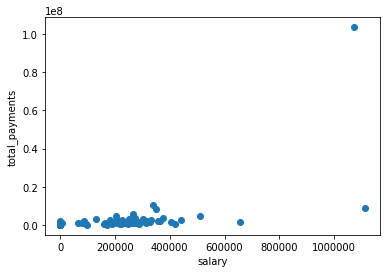

In [0]:
# Graph for features

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(enron_df['salary'], enron_df['total_payments'])
plt.xlabel("salary")
plt.ylabel("total_payments")
plt.show()


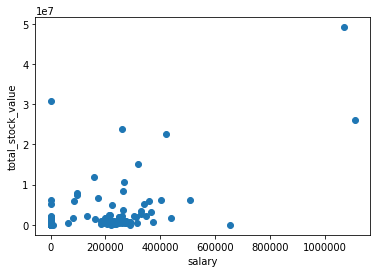

In [0]:
plt.scatter(enron_df['salary'], enron_df['total_stock_value'])
plt.xlabel("salary")
plt.ylabel("total_stock_value")
plt.show()

In [21]:
# 提取目標值'poi'
train_Y = enron_df['poi']
train_Y.shape

(112,)

In [22]:
enron_df.keys()

Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'director_fees', 'exercised_stock_options', 'expenses', 'from_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances',
       'long_term_incentive', 'other', 'poi', 'restricted_stock',
       'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
       'to_messages', 'total_payments', 'total_stock_value'],
      dtype='object')

In [0]:
enron_test_df = df_test_imp

In [0]:
enron_df = enron_df.drop(['name', 'poi'] , axis=1)
enron_test_df = enron_test_df.drop(['name'], axis=1)

In [0]:
# 使用三種模型 : 線性迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
linear = LinearRegression(normalize=False, fit_intercept=True, copy_X=True)
gdbt = GradientBoostingRegressor(tol=0.1, subsample=0.37, n_estimators=200, max_features=20, 
                                 max_depth=6, learning_rate=0.03)
rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=8, bootstrap=False)

In [0]:
# 隨機森林預測檔
rf.fit(enron_df, train_Y)
rf_pred = rf.predict(enron_test_df)
sub = pd.DataFrame({'name': names, 'poi': np.expm1(rf_pred)})
sub.to_csv('enron_rf.csv', index=False)


In [0]:
# 混合泛化預測檔 (依 Kaggle 傳回分數調整比重, 越準確者比重越高, 依資料性質有所不同)
blending_pred = linear_pred*0.30 + rf_pred*0.70
sub = pd.DataFrame({'name': names, 'poi': np.expm1(blending_pred)})
sub.to_csv('enron_blending.csv', index=False)

In [0]:
# # 梯度提升機預測檔 
# gdbt.fit(enron_df, train_Y)
# gdbt_pred = gdbt.predict(enron_test_df)
# sub = pd.DataFrame({'name': names, 'poi': np.expm1(gdbt_pred)})
# sub.to_csv('enron_gdbt.csv', index=False)


In [0]:
# 線性迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準, 以下模型同理)
linear.fit(enron_df, train_Y)
linear_pred = linear.predict(enron_test_df)
sub = pd.DataFrame({'name': names, 'poi': np.expm1(linear_pred)})
sub.to_csv('enron_linear.csv', index=False) 


In [30]:
!pip install mlxtend

In [0]:
# 堆疊泛化套件 mlxtend, 需要先行安裝(使用 pip 安裝即可)在執行環境下
from mlxtend.regressor import StackingRegressor

# 因為 Stacking 需要以模型作為第一層的特徵來源, 因此在 StackingRegressor 中,
# 除了要設本身(第二層)的判定模型 - meta_regressor, 也必須填入第一層的單模作為編碼器 - regressors
# 這裡第二層模型(meta_regressor)的參數, 一樣也需要用 Grid/Random Search, 請參閱講義中的 mlxtrend 網頁
meta_estimator = GradientBoostingRegressor(tol=10, subsample=0.44, n_estimators=100, 
                                           max_features='log2', max_depth=4, learning_rate=0.1)
stacking = StackingRegressor(regressors=[linear, rf], meta_regressor=meta_estimator)

In [0]:
# 堆疊泛化預測檔 : 分數會依每次執行略有出入, 但通常 Public Score(競賽中的提交分數) 會再比單模好一些
# 雖然 Public Score 有可能比 Blending 分數略差, 但是因為不用依賴仔細調整的權重參數, 競賽結束時的 Private Score, 通常會比 Blending 好
# (因為權重依賴於 Public 的分數表現), 這種在未知 / 未曝光資料的預測力提升, 就是我們所謂 "泛化能力比較好" 在競賽/專案中的含意
stacking.fit(enron_df, train_Y)
stacking_pred = stacking.predict(enron_test_df)
sub = pd.DataFrame({'name': names, 'poi': np.expm1(stacking_pred)})
sub.to_csv('enron_stacking.csv', index=False)

In [40]:
result = pd.read_csv('enron_rf.csv')
result

,name,poi
0,BELDEN TIMOTHY N,0.310723
1,BOWEN JR RAYMOND M,0.325620
2,HANNON KEVIN P,0.501637
3,DELAINEY DAVID W,0.255106
4,CAUSEY RICHARD A,0.456376
5,HICKERSON GARY J,0.314294
6,FREVERT MARK A,0.596376
7,CHAN RONNIE,0.006165
8,DONAHUE JR JEFFREY M,0.155062
9,REYNOLDS LAWRENCE,0.114748


In [0]:
enron_df[enron_df['total_stock_value'].isnull()]


,name,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value


方法二

In [0]:
import pandas as pd
import numpy as np
import copy, time
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [0]:
# df_train = pd.read_csv('train_data.csv', index_col="name")
df_train = pd.read_csv('train_data.csv')
# df_test = pd.read_csv('test_features.csv', index_col="name")
df_test = pd.read_csv('test_features.csv')

names = df_test['name']

In [3]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bonus,61.0,1.147436e+06,1.505189e+06,70000.0,450000.00,750000.0,1000000.00,8000000.0
deferral_payments,28.0,6.344374e+05,8.603646e+05,-102500.0,76567.50,195190.0,834205.25,2964506.0
deferred_income,34.0,-4.625664e+05,8.095392e+05,-3504386.0,-552703.25,-117534.0,-27083.25,-1042.0
director_fees,13.0,8.939785e+04,4.114339e+04,3285.0,101250.00,108579.0,112492.00,125034.0
exercised_stock_options,81.0,2.985081e+06,6.004174e+06,3285.0,400478.00,850010.0,2165172.00,34348384.0
expenses,73.0,5.104055e+04,4.759668e+04,148.0,18834.00,41953.0,59175.00,228763.0
from_messages,65.0,7.113231e+02,2.074498e+03,12.0,19.00,45.0,215.00,14368.0
from_poi_to_this_person,65.0,6.480000e+01,9.186321e+01,0.0,10.00,28.0,88.00,528.0
from_this_person_to_poi,65.0,4.009231e+01,8.890141e+01,0.0,0.00,7.0,27.00,411.0
loan_advances,2.0,4.096250e+07,5.736404e+07,400000.0,20681250.00,40962500.0,61243750.00,81525000.0


In [0]:
# 將'NaN'替換成0

df_train.replace(to_replace='NaN', value=np.nan, inplace=True)
df_test.replace(to_replace='NaN', value=np.nan, inplace=True)

df_train.replace(to_replace=np.nan, value=0.0, inplace=True)
df_test.replace(to_replace=np.nan, value=0.0, inplace=True)

df_imp = df_train.fillna(0).copy(deep=True)
df_test_imp = df_test.fillna(0).copy(deep=True)


In [9]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
# print(df_test.isnull().sum())

,Missing Ratio


In [14]:
na_check(df_imp)

,Missing Ratio


In [0]:
# Remove Outlier
df_imp.drop(df_imp[df_imp['name'].isin(['THE TRAVEL AGENCY IN THE PARK'])].index, axis = 0, inplace=True)
df_imp.drop(df_imp[df_imp['name'].isin(['LOCKHART EUGENE E'])].index, axis = 0, inplace=True)

In [19]:
# 檢查'THE TRAVEL AGENCY IN THE PARK'是否還存在
df_imp[df_imp['name'].isin(['THE TRAVEL AGENCY IN THE PARK'])]

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value


In [21]:
print(df_imp.shape)
print(df_test_imp.shape)

(111, 22)
(33, 21)


In [0]:
# remove email address column
if 'email_address' in list(df_imp.columns.values):
    df_imp.drop('email_address', axis=1, inplace=True)
    
if 'email_address' in list(df_test_imp.columns.values):
    df_test_imp.drop('email_address', axis=1, inplace=True)

In [24]:
enron_df = df_imp
enron_test_df = df_test_imp

print(enron_df.shape)
print(enron_test_df.shape)

(111, 21)
(33, 20)


In [25]:
# 提取目標值'poi'
train_Y = enron_df['poi']
print(train_Y.shape)

(111,)


In [26]:
# 確認訓練集與測試集都沒有空缺值
print(enron_df.isnull().sum())
print(enron_test_df.isnull().sum())

name                         0
bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
exercised_stock_options      0
expenses                     0
from_messages                0
from_poi_to_this_person      0
from_this_person_to_poi      0
loan_advances                0
long_term_incentive          0
other                        0
poi                          0
restricted_stock             0
restricted_stock_deferred    0
salary                       0
shared_receipt_with_poi      0
to_messages                  0
total_payments               0
total_stock_value            0
dtype: int64
name                         0
bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
exercised_stock_options      0
expenses                     0
from_messages                0
from_poi_to_this_person      0
from_this_person_to_poi      0
loan_advances             

In [0]:
# #Create new feature(s)
# df_train["fraction_from_poi"] = df_train["from_poi_to_this_person"].\
# divide(df_train["to_messages"], fill_value = 0)

# df_train["fraction_to_poi"] = df_train["from_this_person_to_poi"].\
# divide(df_train["from_messages"], fill_value = 0)

In [0]:
# df_train["fraction_from_poi"] = df_train["fraction_from_poi"].fillna(0.0)
# df_train["fraction_to_poi"] = df_train["fraction_to_poi"].fillna(0.0)

In [0]:
# 將訓練集去除'name', 'poi'，測試集去除'name'
enron_df = enron_df.drop(['name', 'poi'] , axis=1)
enron_test_df = enron_test_df.drop(['name'], axis=1)

In [29]:
# 查看最終shape
print(enron_df.shape)
print(enron_test_df.shape)

(111, 19)
(33, 19)


In [0]:
# 訓練資料
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
random_state = 42
gnb = GaussianNB()
svc = SVC()
knn = KNeighborsClassifier()
log = LogisticRegression(random_state=random_state)
rfc = RandomForestClassifier(random_state=random_state)
mlp = MLPClassifier(random_state=random_state)

In [0]:
classifiers = [gnb, svc, knn, log, rfc, mlp]
for clf in classifiers:
    clf.fit(enron_df, train_Y)
    if clf == gnb:
      gnd_pred = clf.predict(enron_test_df)
      sub = pd.DataFrame({'name': names, 'poi': np.expm1(gnd_pred)})
      sub.to_csv('enron_gnd.csv', index=False) 
      
    elif clf == svc:
      svc_pred = clf.predict(enron_test_df)
      sub = pd.DataFrame({'name': names, 'poi': np.expm1(svc_pred)})
      sub.to_csv('enron_svc.csv', index=False)
      
    elif clf == knn:
      knn_pred = clf.predict(enron_test_df)
      sub = pd.DataFrame({'name': names, 'poi': np.expm1(knn_pred)})
      sub.to_csv('enron_knn.csv', index=False)
      
    elif clf == log:
      log_pred = clf.predict(enron_test_df)
      sub = pd.DataFrame({'name': names, 'poi': np.expm1(log_pred)})
      sub.to_csv('enron_log.csv', index=False)
    
    elif clf == rfc:
      rfc_pred = clf.predict(enron_test_df)
      sub = pd.DataFrame({'name': names, 'poi': np.expm1(rfc_pred)})
      sub.to_csv('enron_rfc.csv', index=False)
      
    else :
      mlp_pred = clf.predict(enron_test_df)
      sub = pd.DataFrame({'name': names, 'poi': np.expm1(mlp_pred)})
      sub.to_csv('enron_mlp.csv', index=False)

# 參考:https://sudonull.com/posts/3372-Identify-fraud-using-Enron-dataset-Part-2-the-search-for-the-optimal-model

In [41]:
result = pd.read_csv('enron_rfc.csv')
result

,name,poi
0,BELDEN TIMOTHY N,0.000
1,BOWEN JR RAYMOND M,0.000
2,HANNON KEVIN P,1.719
3,DELAINEY DAVID W,0.000
4,CAUSEY RICHARD A,0.000
5,HICKERSON GARY J,0.000
6,FREVERT MARK A,1.719
7,CHAN RONNIE,0.000
8,DONAHUE JR JEFFREY M,0.000
9,REYNOLDS LAWRENCE,0.000
